# DRAFT STATE

Warning: This unit is in a draft state, with TODOs.

Remove this text block when these are resolved. 

# Exercise: Gradient Descent

Previously we identified trends in winter and autumnal temperatures by fitting a linear regression model to weather data.

Here, we will take a deeper dive into the model fitting process. Specifically, we will work with batch gradient descent and explore how changing the learning rate can alter its behaviour.

The model we will be working with will be the same linear regression model we have used in other units. The principles we learn, however, apply to much more complex models too.

## Loading data and preparing our model

Let's load up our weather data from Seattle, filter to the first 6 months of the year, and make slight adjustments so that the dates are mathematically interpretable.


Visual Check:


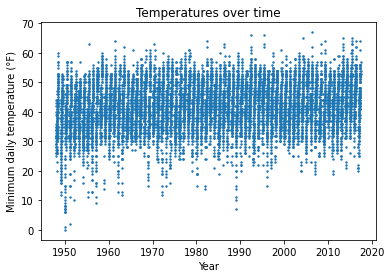

In [1]:
import matplotlib.pyplot as graph
from datetime import datetime
import pandas

# Load a file containing weather data for Seattle
data = pandas.read_csv('Data/seattleWeather_1948-2017.csv', parse_dates=['date'])

# Remove all dates after July 1st because we have to to plant onions before summer begins
data = data[[d.month < 7 for d in data.date]].copy()


# Convert the dates into numbers so we can use it in our models
# We make a year column which can contain fractions. For example
# 1948.5 is half way through the year 1948
data["year"] = [(d.year + d.timetuple().tm_yday / 365.25) for d in data.date]

# Let's take a quick look at our data
# Don't worry about how this is done for now
print("\nVisual Check:")
%matplotlib inline  
graph.scatter(data.year, data.min_temperature, s=2)
graph.ylabel('Minimum daily temperature (°F)')
graph.xlabel("Year")
graph.title('Temperatures over time')
graph.show()


## Fitting a model automatically

We already know we can fit a line to this data well using existing libraries. Let's do that now.

In [2]:
import statsmodels.formula.api as smf

# Perform linear regression to fit a line to our data
model = smf.ols(formula = "min_temperature ~ year", data = data).fit()

# Print the model
intercept = model.params[0]
slope = model.params[1]

print(f"The model is: y = {slope} * x + {intercept}")

C:\Users\leere\Anaconda3\envs\ml_crash_course\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
The model is: y = 0.06294086653213238 * x + -83.07288146914607


Hopefully this is familiar for you from the previous two exercises. If not:
* `y` is temperature (°F)
* `x` is year
* -83 is a _model parameter_ that acts as the line offset  
* 0.063 is a _model parameter_ that defines the line slope (in temperature per year)

How did the library calculate these values?


## Fitting our model with gradient descent

We know, from our previous exercises, that OLS used the square differences of residuals as a cost function. Let's replicate the above line fitting, and break down each step so we can watch it in action.

Recall that for each iteration, our training conducts three steps: 

1) Estimation of `y` (temperature) from `X` (year)

2) Calculation of the cost function and its slope

3) Adjustment of our model according to this slope

Let's implement this now, to watch it in action. Note that, to keep things simple, we'll focus on estimating one parameter (line slope) for now.

### Visualising the error function

First, lets look at the error function for this data. Normally we don't know this in advance, but for learning purposes, we can calculate it now for different potential models

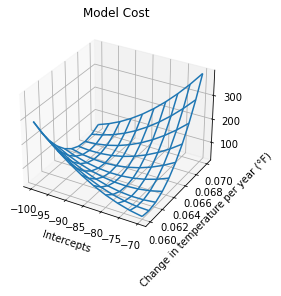

In [3]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

x = data.year
y_true = data.min_temperature


# Our cost function can be half the mean of squared differences
def cost_function(y_estimate):
    """
    Our cost function is the mean squared error divided by 2
    """
    # Note that with numpy to square each value we use **
    # We use MSE/2 because it makes the gradient easier to calculate
    mse = np.sum((y_true - y_estimate) ** 2) / (2*len(y_estimate))
    return mse


# TODO - this needs tidying/vectorising
intercepts, slopes = np.meshgrid(np.linspace(-100,-70,10), np.linspace(0.060,0.07,10))

errors = []
for intercept in np.linspace(-100,-70,10):
    for slope in np.linspace(0.060,0.07,10):
        error = cost_function(slope * x + intercept)
        errors.append(error)

errors = np.array(errors).reshape((10,10))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
graph.ylabel('Change in temperature per year (°F)')
graph.xlabel("Intercepts")
graph.title('Model Cost')


ax.plot_wireframe(intercepts, slopes, errors)

plt.show()

Notice how the curve above is a 2D surface - it changes with both intercept and with line slope. This makes sense - a line has a slope and an intercept, which both will affect how well the line fits the data. A consequence is that the gradient of the cost function must also be described by two numbers - one for intercept, and one for line slope.

Our lowest point on the graph is the location of the best line equation for our data: a slope of 0.063 and intercept of -83. Let's try to train a model to find this point.

### Implementing Gradient Descent

First we need a method that can calculate the gradient of the above curve. 

In [4]:
def calculate_gradient(y_estimate):
    """
    This calculates gradient for a linear regession 
    using the MSE cost function:
    cost = mean((predicted - actual)^2)
    """

    # The partial derivatives of MSE/2 are as follows
    # You don't need to be able to do this just yet but
    # it is important to note these give you the two gradients
    # that we need to train our model
    error = y_estimate - y_true
    grad_intercept = np.mean(error)
    grad_slope = (x * error).sum() / x.shape[0]

    return grad_intercept, grad_slope

Now we need a starting guess, and a loop that will update this guess with each iteration 

In [5]:
def gradient_descent(learning_rate, number_of_iterations):
    """
    Performs gradient descent for a one-variable function. 

    learning_rate: Larger numbers follow the gradient more aggressively
    number_of_iterations: The maximum number of iterations to perform
    """

    # Our starting guess is y = 0 * x - 83
    # We are going to start with the correct intercept so that 
    # only the line's slope is estimated. This is just to keep
    # things simple for this unit
    estimated_intercept = -83
    estimated_slope = 0

    for i in range(number_of_iterations):
        # Calculate the predicted values
        predicted_y = estimated_slope * x + estimated_intercept

        # Calculate the gradient
        _, grad_slope = calculate_gradient(predicted_y)

        # Update the estimation of the line
        estimated_slope -= learning_rate * grad_slope

        # Print the current estimation and cost every 100 iterations
        if( i % 100 == 0):
            estimate = estimated_slope * x + estimated_intercept
            cost = cost_function(estimate)
            print(f"Next estimate: y={estimated_slope}x + {estimated_intercept}. Cost: {cost}")

    # Print the final model
    print(f"Final estimate: y={estimated_slope}x + {estimated_intercept}")

# Run gradient descent
gradient_descent(learning_rate=1E-9, number_of_iterations=1200)

Next estimate: y=0.00024732016606679073x + -83. Cost: 7747.838936389432
Next estimate: y=0.020648928667913787x + -83. Cost: 3540.1854069849
Next estimate: y=0.034407592110134104x + -83. Cost: 1626.5303943737147
Next estimate: y=0.04368631244726597x + -83. Cost: 756.1936421435045
Next estimate: y=0.049943798972484084x + -83. Cost: 360.36155261288405
Next estimate: y=0.0541637922679593x + -83. Cost: 180.33578362096117
Next estimate: y=0.057009718238728385x + -83. Cost: 98.45945686947354
Next estimate: y=0.05892898541855596x + -83. Cost: 61.221827390900515
Next estimate: y=0.060223322146003504x + -83. Cost: 44.28602794557085
Next estimate: y=0.06109621133080689x + -83. Cost: 36.5835692534174
Next estimate: y=0.06168488003871673x + -83. Cost: 33.08046506894407
Next estimate: y=0.06208187298318797x + -83. Cost: 31.487241474019168
Final estimate: y=0.06234741271908692x + -83


Our model found the correct answer, but it took a number of steps. Looking at the print out we can see how it progressively stepped toward the correct solution.

Now, what happens if we make the learning rate faster? This means taking larger steps

In [6]:
gradient_descent(learning_rate=1E-8, number_of_iterations=200)

Next estimate: y=0.0024732016606679075x + -83. Cost: 7209.23787974477
Next estimate: y=0.06180947783033277x + -83. Cost: 32.51370495747876
Final estimate: y=0.06288347305517156x + -83


It appears to have found the solution faster. If we increase the rate even faster, however, things don't go so well:

In [14]:
gradient_descent(learning_rate=1E-6, number_of_iterations=500)

Next estimate: y=0.24732016606679072x + -83. Cost: 66887.32085720467
Next estimate: y=9.500952345613634e+45x + -83. Cost: 1.7745358336457816e+98
Next estimate: y=4.8948068107652476e+92x + -83. Cost: 4.7100075720878505e+191
Next estimate: y=2.52176127646564e+139x + -83. Cost: 1.2501393834097756e+285
Next estimate: y=1.2991891572708264e+186x + -83. Cost: inf
Final estimate: y=-2.2830799448010082e+232x + -83


As we can see, the model became unstable and it did not manage to find the correct solution. 

This is because the steps it was taking were too large. While it would step towards the correct solution, it would step too far and actually get worse with each attempt.

For each model, there is an ideal learning rate. This is something that requires experimentation.

## Fitting multiple variables simultaneously

We've just fit one variable here to keep things simple. Expanding this to fit multiple variables requires only a few small code changes:

1) We need to update more than one variable in the gradient descent loop

2) We need to do some pre-processing of the data. We will cover how and why in a later module. 

## Summary

Well done! In this unit we have:

1) watched gradient descent in action

2) seen how changing the learning rate can improve a model's training speed

3) learned that changing the learning rate can also result in unstable models 